<a href="https://colab.research.google.com/github/seawavve/Network_wavve/blob/main/RepNet/Counter_TSM_Standazation_linePrint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2020 Google LLC.

Licensed aunder the Apache License, Version 2.0 (the "License");

In [ ]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# RepNet

This colab contains a pre-trained [RepNet](https://sites.google.com/view/repnet) model. It can be used to predict the rate at which repetitions are happening in a video in a class-agnostic manner. These estimates can be used to count the number of repetitions in videos.

This model is able to count repetitions in many domains: counting the number of reps while exercising, measuring the rate of biological events like heartrates etc. 

Ensure you are running the Colab with a GPU runtime.


# Setup



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title
import base64
import io
import os
import time
import math

import cv2

from IPython.display import display
from IPython.display import HTML
from IPython.display import Javascript

import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
from scipy.signal import medfilt

import tensorflow.compat.v2 as tf
import tensorflow as originTF

from google.colab import drive
from google.colab import output
from google.colab.output import eval_js

from sklearn.preprocessing import StandardScaler


# Model definition
layers = tf.keras.layers
regularizers = tf.keras.regularizers
FRAME=3950

In [3]:
class ResnetPeriodEstimator(tf.keras.models.Model):
  """RepNet model."""
#DROPOUT_RATE=0.25 -> 0.7
#TRANSFORMER_DROPOUT_RATE=0.0 -> 0.7
  def __init__(
      self,
      num_frames=FRAME,
      image_size=112,
      base_model_layer_name='conv4_block3_out',
      temperature=13.544,
      dropout_rate=0.6,
      l2_reg_weight=1e-6,
      temporal_conv_channels=512,
      temporal_conv_kernel_size=3,
      temporal_conv_dilation_rate=3,
      conv_channels=32,
      conv_kernel_size=3,
      transformer_layers_config=((512, 4, 512),),
      transformer_dropout_rate=0.5,
      transformer_reorder_ln=True,
      period_fc_channels=(512, 512),
      within_period_fc_channels=(512, 512)):
    super(ResnetPeriodEstimator, self).__init__()


    

    # Model params.
    self.num_frames = num_frames
    self.image_size = image_size

    self.base_model_layer_name = base_model_layer_name

    self.temperature = temperature

    self.dropout_rate = dropout_rate
    self.l2_reg_weight = l2_reg_weight

    self.temporal_conv_channels = temporal_conv_channels
    self.temporal_conv_kernel_size = temporal_conv_kernel_size
    self.temporal_conv_dilation_rate = temporal_conv_dilation_rate

    self.conv_channels = conv_channels
    self.conv_kernel_size = conv_kernel_size
    # Transformer config in form of (channels, heads, bottleneck channels).
    self.transformer_layers_config = transformer_layers_config
    self.transformer_dropout_rate = transformer_dropout_rate
    self.transformer_reorder_ln = transformer_reorder_ln

    self.period_fc_channels = period_fc_channels
    self.within_period_fc_channels = within_period_fc_channels

  ####################################################
    # Convolutional feature extractor Base ResNet50 Model.
    # 112x112x3 → 7x7x1024
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False, weights=None, pooling='max')
    self.base_model = tf.keras.models.Model(
        inputs=base_model.input,
        outputs=base_model.get_layer(self.base_model_layer_name).output)
  #####################################################
    # Temporal Context
    # 3x3x3 512filters with RELU
    # 3D Conv on k Frames
    self.temporal_conv_layers = [
        layers.Conv3D(self.temporal_conv_channels,
                      self.temporal_conv_kernel_size,
                      padding='same',
                      dilation_rate=(self.temporal_conv_dilation_rate, 1, 1),
                      kernel_regularizer=regularizers.l2(self.l2_reg_weight),
                      kernel_initializer='he_normal')]
    self.temporal_bn_layers = [layers.BatchNormalization()
                               for _ in self.temporal_conv_layers]

    # Counting Module (Self-sim > Conv > Transformer > Classifier)
    self.conv_3x3_layer = layers.Conv2D(self.conv_channels,
                                        self.conv_kernel_size,
                                        padding='same',
                                        activation=tf.nn.relu)

    channels = self.transformer_layers_config[0][0]
    self.input_projection = layers.Dense(
        channels, kernel_regularizer=regularizers.l2(self.l2_reg_weight),
        activation=None)
    self.input_projection2 = layers.Dense(
        channels, kernel_regularizer=regularizers.l2(self.l2_reg_weight),
        activation=None)

    length = self.num_frames
    self.pos_encoding = tf.compat.v1.get_variable(
        name='resnet_period_estimator/pos_encoding',
        shape=[1, length, 1],
        initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02))
    self.pos_encoding2 = tf.compat.v1.get_variable(
        name='resnet_period_estimator/pos_encoding2',
        shape=[1, length, 1],
        initializer=tf.compat.v1.truncated_normal_initializer(stddev=0.02))

    self.transformer_layers = []
    for d_model, num_heads, dff in self.transformer_layers_config:
      self.transformer_layers.append(
          TransformerLayer(d_model, num_heads, dff,
                           self.transformer_dropout_rate,
                           self.transformer_reorder_ln))

    self.transformer_layers2 = []
    for d_model, num_heads, dff in self.transformer_layers_config:
      self.transformer_layers2.append(
          TransformerLayer(d_model, num_heads, dff,
                           self.transformer_dropout_rate,
                           self.transformer_reorder_ln))

    # Period Prediction Module.
    self.dropout_layer = layers.Dropout(self.dropout_rate)
    num_preds = self.num_frames//2
    self.fc_layers = []
    for channels in self.period_fc_channels:
      self.fc_layers.append(layers.Dense(
          channels, kernel_regularizer=regularizers.l2(self.l2_reg_weight),
          activation=tf.nn.relu))
    self.fc_layers.append(layers.Dense(
        num_preds, kernel_regularizer=regularizers.l2(self.l2_reg_weight)))

    # Within Period Module
    num_preds = 1
    self.within_period_fc_layers = []
    for channels in self.within_period_fc_channels:
      self.within_period_fc_layers.append(layers.Dense(
          channels, kernel_regularizer=regularizers.l2(self.l2_reg_weight),
          activation=tf.nn.relu))
    self.within_period_fc_layers.append(layers.Dense(
        num_preds, kernel_regularizer=regularizers.l2(self.l2_reg_weight)))

  def call(self, x):
    # Ensures we are always using the right batch_size during train/eval.
    batch_size = tf.shape(x)[0]
    # Conv Feature Extractor.
    x = tf.reshape(x, [-1, self.image_size, self.image_size, 3])
    #----------------Convolutional feature extractor Base ResNet50 Model----------------#
    # 112x112x3 → 7x7x1024
    x = self.base_model(x) #<base model이 ResNet-50
    h = tf.shape(x)[1]
    w = tf.shape(x)[2]
    c = tf.shape(x)[3]
    x = tf.reshape(x, [batch_size, -1, h, w, c])
    #-------------------Temporal Context-------------------------#
    # 3x3x3 512filters with RELU
    # 3D Conv to give temporal context to per-frame embeddings. 
    for bn_layer, conv_layer in zip(self.temporal_bn_layers,
                                    self.temporal_conv_layers):
      x = conv_layer(x)
      x = bn_layer(x)
      x = tf.nn.relu(x)

    #-----------------Dimensionality reduction--------------------#
    x = tf.reduce_max(x, [2, 3])

    # Reshape and prepare embs for output.
    final_embs = x
    #-----------------Get self-similarity matrix-----------------#
    originTF.config.run_functions_eagerly(True)
    x = get_sims(x, self.temperature)
    #assert originTF.executing_eagerly(),'WHY.........'
    x_np = np.reshape(x, (-1))
    x_np = np.reshape(x_np,(self.num_frames,-1))
    #sklearn.preprocessing 을 이용한 표준화
    x_np = StandardScaler().fit_transform(x_np)
    new_np=np.array(x_np)
    plt.imshow(new_np, cmap='hot', interpolation='nearest')
    plt.show()
    print(new_np)

    #------count line 확인----#
    print('count line: ',new_np[138])
    line=new_np[138]
    for num in range(len(line)):
      print(num,':',line[num])








    #---------count 확인----------#
    count_frames=[138, 150, 570, 1430, 2200, 2670, 3020,3370]
    # for count_frame in count_frames:
    #   x_np[count_frame][count_frame]=20
    #   x_np[count_frame-1][count_frame]=20
    #   x_np[count_frame][count_frame-1]=20
    #   x_np[count_frame-1][count_frame-1]=20
    # x_np=np.array(x_np)

    
    # plt.imshow(x_np, cmap='hot', interpolation='nearest')
    # plt.show()

    


    print(originTF.executing_eagerly())
    #print(x.numpy())

    # reduction = np.squeeze(x.numpy(), axis=1)
    # print(reduction)
    print('batch_size: ',batch_size)
    print('num_frames: ',self.num_frames)
    print('len(x_np)/batch_size:',len(x_np)/batch_size)
##################################################################################


    # # 3x3 conv layer on self-similarity matrix.
    # x = self.conv_3x3_layer(x)
    # x = tf.reshape(x, [batch_size, self.num_frames, -1])
    # within_period_x = x

    # # Period prediction.
    # x = self.input_projection(x)
    # x += self.pos_encoding
    # for transformer_layer in self.transformer_layers:
    #   x = transformer_layer(x)
    # x = flatten_sequential_feats(x, batch_size, self.num_frames)
    # for fc_layer in self.fc_layers:
    #   x = self.dropout_layer(x)
    #   x = fc_layer(x)

    # # Within period prediction.
    # within_period_x = self.input_projection2(within_period_x)
    # within_period_x += self.pos_encoding2
    # for transformer_layer in self.transformer_layers2:
    #   within_period_x = transformer_layer(within_period_x)
    # within_period_x = flatten_sequential_feats(within_period_x,
    #                                            batch_size,
    #                                            self.num_frames)
    # for fc_layer in self.within_period_fc_layers:
    #   within_period_x = self.dropout_layer(within_period_x)
    #   within_period_x = fc_layer(within_period_x)

    x,within_period_x,final_emb=1,2,3
    return x, within_period_x, final_embs
    

#  @tf.function
  def preprocess(self, imgs):
    imgs = tf.cast(imgs, tf.float32)
    imgs -= 127.5
    imgs /= 127.5
    imgs = tf.image.resize(imgs, (self.image_size, self.image_size))
    return imgs


def get_sims(embs, temperature):
  """Calculates self-similarity between batch of sequence of embeddings."""
  batch_size = tf.shape(embs)[0]
  seq_len = tf.shape(embs)[1]
  embs = tf.reshape(embs, [batch_size, seq_len, -1])

  def _get_sims(embs):
    """Calculates self-similarity between sequence of embeddings."""
    dist = pairwise_l2_distance(embs, embs)
    sims = -1.0 * dist
    return sims

  sims = tf.map_fn(_get_sims, embs)
  sims /= temperature
  sims = tf.nn.softmax(sims, axis=-1)
  sims = tf.expand_dims(sims, -1)
  return sims


def flatten_sequential_feats(x, batch_size, seq_len):
  """Flattens sequential features with known batch size and seq_len."""
  x = tf.reshape(x, [batch_size, seq_len, -1])
  return x


# Transformer from https://www.tensorflow.org/tutorials/text/transformer .
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.

  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    outputs: shape == (..., seq_len_q, depth_v)
    attention_weights: shape == (..., seq_len_q, seq_len_k)
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk.
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  # (..., seq_len_q, seq_len_k)
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

  outputs = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return outputs, attention_weights


def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model)
  ])


class MultiHeadAttention(tf.keras.layers.Layer):
  """Multi-headed attention layer."""

  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth)."""
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(
        q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(
        k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(
        v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(
        scaled_attention,
        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(
        scaled_attention,
        (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    outputs = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return outputs, attention_weights


class TransformerLayer(tf.keras.layers.Layer):
  """Implements a single transformer layer (https://arxiv.org/abs/1706.03762).
  """

  def __init__(self, d_model, num_heads, dff,
               dropout_rate=0.1,
               reorder_ln=False):
    super(TransformerLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
    self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    self.reorder_ln = reorder_ln

  def call(self, x):
    inp_x = x

    if self.reorder_ln:
      x = self.layernorm1(x)

    # (batch_size, input_seq_len, d_model)
    attn_output, _ = self.mha(x, x, x, mask=None)
    attn_output = self.dropout1(attn_output)

    if self.reorder_ln:
      out1 = inp_x + attn_output
      x = out1
    else:
      # (batch_size, input_seq_len, d_model)
      out1 = self.layernorm1(x + attn_output)
      x = out1

    if self.reorder_ln:
      x = self.layernorm2(x)

    # (batch_size, input_seq_len, d_model)
    ffn_output = self.ffn(x)
    ffn_output = self.dropout2(ffn_output)

    if self.reorder_ln:
      out2 = out1 + ffn_output
    else:
      # (batch_size, input_seq_len, d_model)
      out2 = self.layernorm2(out1 + ffn_output)

    return out2


def pairwise_l2_distance(a, b):
  """Computes pairwise distances between all rows of a and all rows of b."""
  norm_a = tf.reduce_sum(tf.square(a), 1)
  norm_a = tf.reshape(norm_a, [-1, 1])
  norm_b = tf.reduce_sum(tf.square(b), 1)
  norm_b = tf.reshape(norm_b, [1, -1])
  dist = tf.maximum(norm_a - 2.0 * tf.matmul(a, b, False, True) + norm_b, 0.0)
  return dist


def get_repnet_model(logdir):
  """Returns a trained RepNet model.

  Args:
    logdir (string): Path to directory where checkpoint will be downloaded.

  Returns:
    model (Keras model): Trained RepNet model.
  """
  # Check if we are in eager mode.
  assert tf.executing_eagerly()

  # Models will be called in eval mode.
  tf.keras.backend.set_learning_phase(0)

  # Define RepNet model.
  model = ResnetPeriodEstimator()
  # tf.function for speed.
  #model.call = tf.function(model.call)

  # # Define checkpoint and checkpoint manager.
  # ckpt = tf.train.Checkpoint(model=model)
  # ckpt_manager = tf.train.CheckpointManager(
  #     ckpt, directory=logdir, max_to_keep=10)
  # latest_ckpt = ckpt_manager.latest_checkpoint
  # print('Loading from: ', latest_ckpt)
  # if not latest_ckpt:
  #   raise ValueError('Path does not have a checkpoint to load.')
  # # Restore weights.
  # print("Restore weights")
  # ckpt.restore(latest_ckpt).expect_partial()
  # print('nice restored!')
  # # Pass dummy frames to build graph.
  model(tf.random.uniform((1, FRAME, 112, 112, 3)))
  return model


def unnorm(query_frame):
  min_v = query_frame.min()
  max_v = query_frame.max()
  query_frame = (query_frame - min_v) / max(1e-7, (max_v - min_v))
  return query_frame


def create_count_video(frames,
                       per_frame_counts,
                       within_period,
                       score,
                       fps,
                       output_file,
                       delay,
                       plot_count=True,
                       plot_within_period=False,
                       plot_score=False):
  """Creates video with running count and within period predictions.

  Args:
    frames (List): List of images in form of NumPy arrays.
    per_frame_counts (List): List of floats indicating repetition count for
      each frame. This is the rate of repetition for that particular frame.
      Summing this list up gives count over entire video.
    within_period (List): List of floats indicating score between 0 and 1 if the
      frame is inside the periodic/repeating portion of a video or not.
    score (float): Score between 0 and 1 indicating the confidence of the
      RepNet model's count predictions.
    fps (int): Frames per second of the input video. Used to scale the
      repetition rate predictions to Hz.
    output_file (string): Path of the output video.
    delay (integer): Delay between each frame in the output video.
    plot_count (boolean): if True plots the count in the output video.
    plot_within_period (boolean): if True plots the per-frame within period
      scores.
    plot_score (boolean): if True plots the confidence of the model along with
      count ot within_period scores.
  """
  if output_file[-4:] not in ['.mp4', '.gif']:
    raise ValueError('Output format can only be mp4 or gif')
  num_frames = len(frames)

  running_counts = np.cumsum(per_frame_counts)
  final_count = running_counts[-1]

  def count(idx):
    return int(np.round(running_counts[idx]))

  def rate(idx):
    return per_frame_counts[idx] * fps

  if plot_count and not plot_within_period:
    fig = plt.figure(figsize=(10, 12), tight_layout=True)
    im = plt.imshow(unnorm(frames[0]))
    if plot_score:
      plt.suptitle('Pred Count: %d, '
                   'Prob: %0.1f' % (int(np.around(final_count)), score),
                   fontsize=24)

    plt.title('Count 0, Rate: 0', fontsize=24)
    plt.axis('off')
    plt.grid(b=None)
    def update_count_plot(i):
      """Updates the count plot."""
      im.set_data(unnorm(frames[i]))
      plt.title('Count %d, Rate: %0.4f Hz' % (count(i), rate(i)), fontsize=24)

    anim = FuncAnimation(
        fig,
        update_count_plot,
        frames=np.arange(1, num_frames),
        interval=delay,
        blit=False)
    if output_file[-3:] == 'mp4':
      anim.save(output_file, dpi=100, fps=24)
    elif output_file[-3:] == 'gif':
      anim.save(output_file, writer='imagemagick', fps=24, dpi=100)

  elif plot_within_period:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    im = axs[0].imshow(unnorm(frames[0]))
    axs[1].plot(0, within_period[0])
    axs[1].set_xlim((0, len(frames)))
    axs[1].set_ylim((0, 1))

    if plot_score:
      plt.suptitle('Pred Count: %d, '
                   'Prob: %0.1f' % (int(np.around(final_count)), score),
                   fontsize=24)

    if plot_count:
      axs[0].set_title('Count 0, Rate: 0', fontsize=20)

    plt.axis('off')
    plt.grid(b=None)

    def update_within_period_plot(i):
      """Updates the within period plot along with count."""
      im.set_data(unnorm(frames[i]))
      axs[0].set_xticks([])
      axs[0].set_yticks([])
      xs = []
      ys = []
      if plot_count:
        axs[0].set_title('Count %d, Rate: %0.4f Hz' % (count(i), rate(i)),
                         fontsize=20)
      for idx in range(i):
        xs.append(idx)
        ys.append(within_period[int(idx * len(within_period) / num_frames)])
      axs[1].clear()
      axs[1].set_title('Within Period or Not', fontsize=20)
      axs[1].set_xlim((0, num_frames))
      axs[1].set_ylim((-0.05, 1.05))
      axs[1].plot(xs, ys)

    anim = FuncAnimation(
        fig,
        update_within_period_plot,
        frames=np.arange(1, num_frames),
        interval=delay,
        blit=False,
    )
    if output_file[-3:] == 'mp4':
      anim.save(output_file, dpi=100, fps=24)
    elif output_file[-3:] == 'gif':
      anim.save(output_file, writer='imagemagick', fps=24, dpi=100)

  plt.close()


def show_video(video_path):
  mp4 = open(video_path, 'rb').read()
  data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
  return HTML("""<video width=600 controls>
      <source src="%s" type="video/mp4"></video>
  """ % data_url)


def viz_reps(frames,
             count,
             score,
             alpha=1.0,
             pichart=True,
             colormap=plt.cm.PuBu,
             num_frames=None,
             interval=30,
             plot_score=True):
  """Visualize repetitions."""
  if isinstance(count, list):
    counts = len(frames) * [count/len(frames)]
  else:
    counts = count
  sum_counts = np.cumsum(counts)
  tmp_path = '/tmp/output.mp4'
  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5),
                         tight_layout=True,)

  h, w, _ = np.shape(frames[0])
  wedge_x = 95 / 112 * w
  wedge_y = 17 / 112 * h
  wedge_r = 15 / 112 * h
  txt_x = 95 / 112 * w
  txt_y = 19 / 112 * h
  otxt_size = 62 / 112 * h

  if plot_score:
    plt.title('Score:%.2f' % score, fontsize=20)
  im0 = ax.imshow(unnorm(frames[0]))

  if not num_frames:
    num_frames = len(frames)

  if pichart:
    wedge1 = matplotlib.patches.Wedge(
        center=(wedge_x, wedge_y),
        r=wedge_r,
        theta1=0,
        theta2=0,
        color=colormap(1.),
        alpha=alpha)
    wedge2 = matplotlib.patches.Wedge(
        center=(wedge_x, wedge_y),
        r=wedge_r,
        theta1=0,
        theta2=0,
        color=colormap(0.5),
        alpha=alpha)

    ax.add_patch(wedge1)
    ax.add_patch(wedge2)
    txt = ax.text(
        txt_x,
        txt_y,
        '0',
        size=35,
        ha='center',
        va='center',
        alpha=0.9,
        color='white',
    )

  else:
    txt = ax.text(
        txt_x,
        txt_y,
        '0',
        size=otxt_size,
        ha='center',
        va='center',
        alpha=0.8,
        color=colormap(0.4),
    )

  def update(i):
    """Update plot with next frame."""
    im0.set_data(unnorm(frames[i]))
    ctr = int(sum_counts[i])
    if pichart:
      if ctr%2 == 0:
        wedge1.set_color(colormap(1.0))
        wedge2.set_color(colormap(0.5))
      else:
        wedge1.set_color(colormap(0.5))
        wedge2.set_color(colormap(1.0))

      wedge1.set_theta1(-90)
      wedge1.set_theta2(-90 - 360 * (1 - sum_counts[i] % 1.0))
      wedge2.set_theta1(-90 - 360 * (1 - sum_counts[i] % 1.0))
      wedge2.set_theta2(-90)

    txt.set_text(int(sum_counts[i]))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

  anim = FuncAnimation(
      fig,
      update,
      frames=num_frames,
      interval=interval,
      blit=False)
  anim.save(tmp_path, dpi=80)
  plt.close()
  return show_video(tmp_path)


def record_video(interval_in_ms, num_frames, quality=0.8):
  """Capture video from webcam."""
  # https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb.

  # Give warning before recording.
  for i in range(0, 3):
    print('Opening webcam in %d seconds'%(3-i))
    time.sleep(1)
    output.clear('status_text')

  js = Javascript('''
    async function recordVideo(interval_in_ms, num_frames, quality) {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // show the video in the HTML element
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight,
        true);

      for (let i = 0; i < num_frames; i++) {
        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        img = canvas.toDataURL('image/jpeg', quality);
        google.colab.kernel.invokeFunction(
        'notebook.get_webcam_video', [img], {});
        await new Promise(resolve => setTimeout(resolve, interval_in_ms));
      }
      stream.getVideoTracks()[0].stop();
      div.remove();
    }
    ''')
  display(js)
  eval_js('recordVideo({},{},{})'.format(interval_in_ms, num_frames, quality))


def data_uri_to_img(uri):
  """Convert base64image to Numpy array."""
  image = base64.b64decode(uri.split(',')[1], validate=True)
  # Binary string to PIL image.
  image = Image.open(io.BytesIO(image))
  image = image.resize((224, 224))
  # PIL to Numpy array.
  image = np.array(np.array(image, dtype=np.uint8), np.float32)
  return image


def read_video(video_filename, width=224, height=224):
  """Read video from file."""
  cap = cv2.VideoCapture(video_filename)
  fps = cap.get(cv2.CAP_PROP_FPS)
  frames = []
  if cap.isOpened():
    while True:
      success, frame_bgr = cap.read()
      if not success:
        break
      frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
      frame_rgb = cv2.resize(frame_rgb, (width, height))
      frames.append(frame_rgb)
  frames = np.asarray(frames)
  return frames, fps


def get_webcam_video(img_b64):
  """Populates global variable imgs by converting image URI to Numpy array."""
  image = data_uri_to_img(img_b64)
  imgs.append(image)


def download_video_from_url(url_to_video,
                            path_to_video='/tmp/video.mp4'):
  if os.path.exists(path_to_video):
    os.remove(path_to_video)
  ydl_opts = {
      'format': 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4',
      'outtmpl': str(path_to_video),
  }
  with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url_to_video])


def get_score(period_score, within_period_score):
  """Combine the period and periodicity scores."""
  within_period_score = tf.nn.sigmoid(within_period_score)[:, 0]
  per_frame_periods = tf.argmax(period_score, axis=-1) + 1
  pred_period_conf = tf.reduce_max(
      tf.nn.softmax(period_score, axis=-1), axis=-1)
  pred_period_conf = tf.where(
      tf.math.less(per_frame_periods, 3), 0.0, pred_period_conf)
  within_period_score *= pred_period_conf
  within_period_score = np.sqrt(within_period_score)
  pred_score = tf.reduce_mean(within_period_score)
  return pred_score, within_period_score


def get_counts(model, frames, strides, batch_size,
               threshold,
               within_period_threshold,
               constant_speed=False,
               median_filter=False,
               fully_periodic=False):
  """Pass frames through model and conver period predictions to count."""
  seq_len = len(frames)
  print('frame number: ',seq_len)
  raw_scores_list = []
  scores = []
  within_period_scores_list = []

  if fully_periodic:
    within_period_threshold = 0.0
  
  #resize processing
  frames = model.preprocess(frames) 

  #strides=[1,2,3,4]
  for stride in strides:
    print('################')
    print('stride:',stride)
    num_batches = int(np.ceil(seq_len/model.num_frames/stride/batch_size))
    print(num_batches)
    raw_scores_per_stride = []
    within_period_score_stride = []
    for batch_idx in range(num_batches):
      print("batch index: ",batch_idx)
      idxes = tf.range(batch_idx*batch_size*model.num_frames*stride,
                       (batch_idx+1)*batch_size*model.num_frames*stride,
                       stride)
      idxes = tf.clip_by_value(idxes, 0, seq_len-1)
      curr_frames = tf.gather(frames, idxes)
      curr_frames = tf.reshape(
          curr_frames,
          [batch_size, model.num_frames, model.image_size, model.image_size, 3])
      raw_scores, within_period_scores, _ = model(curr_frames)
      
  return 1,1,1,1,1


  #     raw_scores_per_stride.append(np.reshape(raw_scores.numpy(),
  #                                             [-1, model.num_frames//2]))
  #     within_period_score_stride.append(np.reshape(within_period_scores.numpy(),
  #                                                  [-1, 1]))
  #   raw_scores_per_stride = np.concatenate(raw_scores_per_stride, axis=0)
  #   raw_scores_list.append(raw_scores_per_stride)
  #   within_period_score_stride = np.concatenate(
  #       within_period_score_stride, axis=0)
  #   pred_score, within_period_score_stride = get_score(
  #       raw_scores_per_stride, within_period_score_stride)
  #   scores.append(pred_score)
  #   within_period_scores_list.append(within_period_score_stride)

  # # Stride chooser
  # argmax_strides = np.argmax(scores)
  # chosen_stride = strides[argmax_strides]
  # raw_scores = np.repeat(
  #     raw_scores_list[argmax_strides], chosen_stride, axis=0)[:seq_len]
  # within_period = np.repeat(
  #     within_period_scores_list[argmax_strides], chosen_stride,
  #     axis=0)[:seq_len]
  # within_period_binary = np.asarray(within_period > within_period_threshold)
  # if median_filter:
  #   within_period_binary = medfilt(within_period_binary, 5)

  # # Select Periodic frames
  # periodic_idxes = np.where(within_period_binary)[0]

  # if constant_speed:
  #   # Count by averaging predictions. Smoother but
  #   # assumes constant speed.
  #   scores = tf.reduce_mean(
  #       tf.nn.softmax(raw_scores[periodic_idxes], axis=-1), axis=0)
  #   max_period = np.argmax(scores)
  #   pred_score = scores[max_period]
  #   pred_period = chosen_stride * (max_period + 1)
  #   per_frame_counts = (
  #       np.asarray(seq_len * [1. / pred_period]) *
  #       np.asarray(within_period_binary))
  # else:
  #   # Count each frame. More noisy but adapts to changes in speed.
  #   pred_score = tf.reduce_mean(within_period)
  #   per_frame_periods = tf.argmax(raw_scores, axis=-1) + 1
  #   per_frame_counts = tf.where(
  #       tf.math.less(per_frame_periods, 3),
  #       0.0,
  #       tf.math.divide(1.0,
  #                      tf.cast(chosen_stride * per_frame_periods, tf.float32)),
  #   )
  #   if median_filter:
  #     per_frame_counts = medfilt(per_frame_counts, 5)

  #   per_frame_counts *= np.asarray(within_period_binary)

  #   pred_period = seq_len/np.sum(per_frame_counts)

  # if pred_score < threshold:
  #   print('No repetitions detected in video as score '
  #         '%0.2f is less than threshold %0.2f.'%(pred_score, threshold))
  #   per_frame_counts = np.asarray(len(per_frame_counts) * [0.])

  # return (pred_period, pred_score, within_period,
  #         per_frame_counts, chosen_stride)

## Load trained RepNet

--2021-10-14 02:26:07--  https://storage.googleapis.com/repnet_ckpt/checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922 [application/octet-stream]
Saving to: ‘/tmp/repnet_ckpt/checkpoint’

checkpoint          100%[===================>]     922  --.-KB/s    in 0s      

2021-10-14 02:26:07 (18.7 MB/s) - ‘/tmp/repnet_ckpt/checkpoint’ saved [922/922]

--2021-10-14 02:26:07--  https://storage.googleapis.com/repnet_ckpt/ckpt-88.data-00000-of-00002
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.128, 74.125.20.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93435 (91K) [application/octet-stream]
Saving to: ‘/tmp/repn

/usr/local/lib/python3.7/dist-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


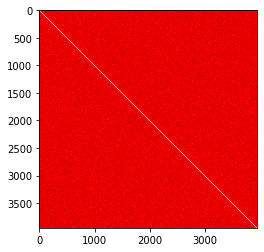

[[34.081577  32.937878  33.048023  ...  4.257523   4.0389256  4.3419333]
 [33.229343  34.323414  33.245346  ...  4.7219367  4.4025073  4.7494574]
 [33.08048   32.986095  34.19945   ...  4.0218     3.7616317  4.1002007]
 ...
 [ 4.4825835  4.927905   4.2302747 ... 34.027386  33.01279   32.96826  ]
 [ 4.2915106  4.636737   3.9929588 ... 33.31588   34.47511   33.32029  ]
 [ 4.645073   5.036392   4.3821616 ... 33.498726  33.54843   34.52424  ]]
count line:  [-1.033891   -0.9754838  -0.9564146  ... -0.3607164  -0.37004972
 -0.3421347 ]
0 : -1.033891
1 : -0.9754838
2 : -0.9564146
3 : 1.7192874
4 : -0.40982696
5 : -0.22194235
6 : 2.6571941
7 : 0.9541808
8 : 1.1812403
9 : 0.30284554
10 : -1.1108665
11 : 0.32459784
12 : 0.7642673
13 : -1.2991492
14 : 0.8209761
15 : 1.1587007
16 : 0.3993358
17 : 0.25472605
18 : 1.7621795
19 : -0.4167379
20 : -0.5201491
21 : 1.2798128
22 : -1.521392
23 : 0.3242945
24 : -0.1368592
25 : -0.44640115
26 : 1.7390336
27 : 1.5088607
28 : -1.0468296
29 : -0.17057511
30 : 

In [4]:
PATH_TO_CKPT = '/tmp/repnet_ckpt/'
!mkdir $PATH_TO_CKPT
!wget -nc -P $PATH_TO_CKPT https://storage.googleapis.com/repnet_ckpt/checkpoint
!wget -nc -P $PATH_TO_CKPT https://storage.googleapis.com/repnet_ckpt/ckpt-88.data-00000-of-00002
!wget -nc -P $PATH_TO_CKPT https://storage.googleapis.com/repnet_ckpt/ckpt-88.data-00001-of-00002
!wget -nc -P $PATH_TO_CKPT https://storage.googleapis.com/repnet_ckpt/ckpt-88.index

model = get_repnet_model(PATH_TO_CKPT)

## Set Params



In [5]:
##@title 

# FPS while recording video from webcam.
WEBCAM_FPS = 16#@param {type:"integer"}

# Time in seconds to record video on webcam. 
RECORDING_TIME_IN_SECONDS = 8. #@param {type:"number"}

# Threshold to consider periodicity in entire video.
THRESHOLD = 0.5#@param {type:"number"}

# Threshold to consider periodicity for individual frames in video.
WITHIN_PERIOD_THRESHOLD = 0.3#@param {type:"number"}

# Use this setting for better results when it is 
# known action is repeating at constant speed.
CONSTANT_SPEED = True#@param {type:"boolean"}

# Use median filtering in time to ignore noisy frames.
MEDIAN_FILTER = True#@param {type:"boolean"}

# Use this setting for better results when it is 
# known the entire video is periodic/reapeating and
# has no aperiodic frames.
FULLY_PERIODIC = False#@param {type:"boolean"}

# Plot score in visualization video.
PLOT_SCORE = False#@param {type:"boolean"}

# Visualization video's FPS.
VIZ_FPS = 30#@param {type:"integer"}

# Get input video

We provide 3 ways to get input video:
1. upload video to your Google Drive.
2. provide URL of a video.
3. record video using webcam.

## Get Video from URL

Provide a link to mp4/gif hosted online.

In [6]:
imgs, vid_fps = read_video("drive/MyDrive/repnet/20201123_180317_croped.mp4")
#show_video("drive/MyDrive/repnet/20201110_120543_croped_half_faster.mp4")

# Run RepNet

Running RepNet...
frame number:  3950
################
stride: 1
1
batch index:  0


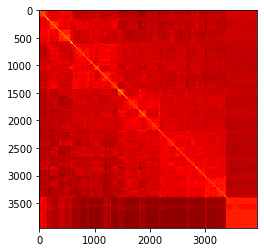

[[14.427291  14.148784  14.427782  ...  2.701987   2.7290912  2.737673 ]
 [14.372936  14.417225  14.670215  ...  2.736452   2.765194   2.7728941]
 [14.214609  14.228053  14.784944  ...  2.49763    2.5268955  2.5337884]
 ...
 [ 4.2509785  4.238023   3.988593  ... 11.142599  11.135093  11.137359 ]
 [ 4.3029838  4.2918587  4.044126  ... 11.159396  11.16646   11.168001 ]
 [ 4.314818   4.3021135  4.0535555 ... 11.1572695 11.163594  11.1667385]]
count line:  [0.2604055  0.2703973  0.25181302 ... 0.35856584 0.3515934  0.35240218]
0 : 0.2604055
1 : 0.2703973
2 : 0.25181302
3 : 1.3917214
4 : 1.2940557
5 : 1.2152075
6 : 1.2396097
7 : 1.2406527
8 : 1.2847968
9 : 1.534993
10 : 1.5755622
11 : 1.5089382
12 : 1.63328
13 : 1.4649508
14 : 1.4477057
15 : 1.5846503
16 : 1.5657315
17 : 1.4864608
18 : 1.3069581
19 : 1.2086084
20 : 1.1125706
21 : 1.1015064
22 : 1.2904222
23 : 1.2390043
24 : 1.2076156
25 : 1.3742965
26 : 1.3706747
27 : 1.359572
28 : 1.4595656
29 : 1.3219717
30 : 1.4900193
31 : 1.5614439
32 :

In [7]:
print('Running RepNet...') 
(pred_period, pred_score, within_period,
 per_frame_counts, chosen_stride) = get_counts(
     model,
     imgs,
     strides=[1],
     batch_size=1,
     threshold=THRESHOLD,
     within_period_threshold=WITHIN_PERIOD_THRESHOLD,
     constant_speed=CONSTANT_SPEED,
     median_filter=MEDIAN_FILTER,
     fully_periodic=FULLY_PERIODIC)
print('END')
#print('Visualizing results...') 
# viz_reps(imgs, per_frame_counts, pred_score, interval=1000/VIZ_FPS,
#          plot_score=PLOT_SCORE)


In [8]:
# Debugging video showing scores, per-frame frequency prediction and 
# within_period scores.

# create_count_video(imgs,
#                    per_frame_counts,
#                    within_period,
#                    score=pred_score,
#                    fps=vid_fps,
#                    output_file='/tmp/debug_video.mp4',
#                    delay=1000/VIZ_FPS,
#                    plot_count=True,
#                    plot_within_period=True,
#                    plot_score=True)
# show_video('/tmp/debug_video.mp4')

# Citation

If you found our paper/code useful in your research, consider citing our paper:


```
@InProceedings{Dwibedi_2020_CVPR,
author = {Dwibedi, Debidatta and Aytar, Yusuf and Tompson, Jonathan and Sermanet, Pierre and Zisserman, Andrew},
title = {Counting Out Time: Class Agnostic Video Repetition Counting in the Wild},
booktitle = {IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
month = {June},
year = {2020}
}
```



